In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
from sklearn import datasets, linear_model, model_selection, metrics
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]


import pmdarima as pm
from pmdarima import model_selection

import torch
import torch.nn as nn



import compare_models_functions as myfxns

# for each model, choose:
#test_size = 7 # how many days to predict = how many days to reserve for testing
#cases_or_deaths = 'cases'
#use_log_counts = True


cases_df, deaths_df = myfxns.load_county_datasets()



# make filtered dataset (currently do not use, only working with counts)
#X_df, X, y = filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
#    use_last_n_days=28,  max_frac_missing=0.1, 
#    use_rel_counts=False, use_log_counts = True, use_counts_only = False)





Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=10.825, BIC=24.316, Time=0.109 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=37.128, BIC=41.625, Time=0.006 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=25.694, BIC=32.440, Time=0.013 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=7.594, BIC=14.339, Time=0.029 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=35.128, BIC=37.377, Time=0.004 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=7.337, BIC=16.331, Time=0.107 seconds
Near non-invertible roots for order (1, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=7.469, BIC=16.463, Time=0.079 seconds
Near non-invertible roots for order (0, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit 

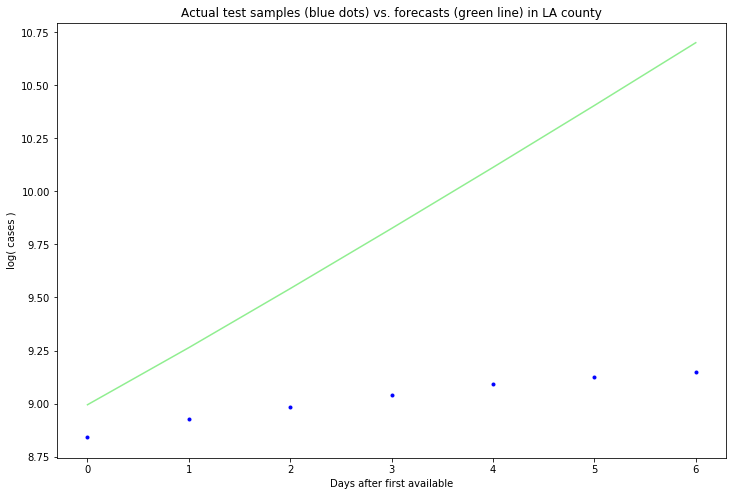

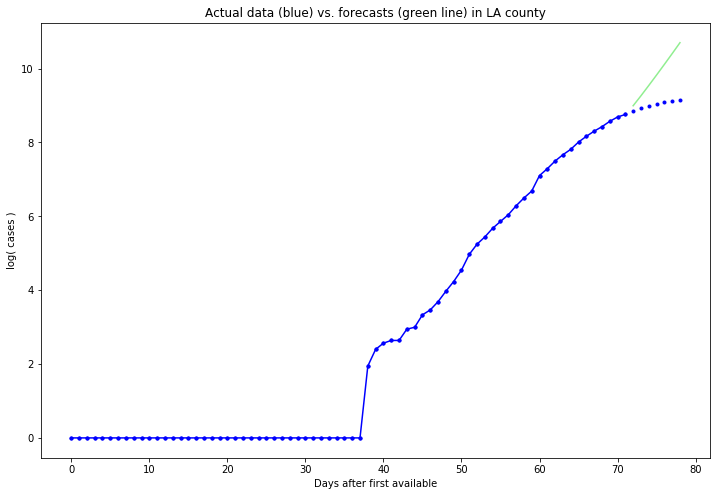

In [80]:
## arima model, fitting each county individually from count data
# example: using LA county (other counties in next cell)



# Load and fit count data for a single county at a time

i = int(np.where(cases_df['fips'] == 6037)[0]) # only do LA for now
counts_mask = [str(c)[:5] == '2020-' for c in cases_df.columns]
if cases_or_deaths == 'cases':
    data = np.array(cases_df.iloc[i,counts_mask].values, dtype='float')
else:
    data = np.array(deaths_df.iloc[i,counts_mask].values, dtype='float')
    
    
# data should be a 1d array of counts over time
# currently start from first date with no missing values (different for each county)
first_nonmiss = np.where(~np.isnan(data))[0][0]
data = data[first_nonmiss:] 
if use_log_counts:
    data = np.log(data)

# split data
train, test = model_selection.train_test_split(data, test_size=test_size)

# fit model -- auto_arima automatically chooses parameters if not specified. can slow if d not set
# m = 1, means non-seasonal
arima_fitted = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=50, m=1)
print('Selected ARIMA order', arima_fitted.get_params()['order'])

# forecast
forecasts = arima_fitted.predict(n_periods=test.shape[0])  # predict N steps into the future


# Plot actual test vs. forecasts
x = np.arange(test.shape[0])  # here, x is date
plt.scatter(x, test, marker='.', color = 'blue')
plt.plot(x, forecasts, color = 'lightgreen')
plt.title('Actual test samples (blue dots) vs. forecasts (green line) in LA county')
plt.xlabel('Days after first available')
if use_log_counts:
    plt.ylabel('log( %s )' % cases_or_deaths)
else:
    plt.ylabel('# %s' % cases_or_deaths)
plt.show()



# same, but showing training data too
x = np.arange(data.shape[0])
plt.scatter(x, data, c='blue', marker='.')
plt.plot(x[:-7], train, c='blue', marker='.') # train line
plt.plot(x[-7:], forecasts, c='lightgreen') # forecast line
plt.title('Actual data (blue) vs. forecasts (green line) in LA county')
plt.xlabel('Days after first available')
if use_log_counts:
    plt.ylabel('log( %s )' % cases_or_deaths)
else:
    plt.ylabel('# %s' % cases_or_deaths)
plt.show()


Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=478.980, BIC=491.838, Time=0.106 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=499.742, BIC=504.028, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=498.256, BIC=504.685, Time=0.018 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=497.388, BIC=503.818, Time=0.018 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=499.856, BIC=501.999, Time=0.004 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=491.693, BIC=502.409, Time=0.050 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=490.020, BIC=500.736, Time=0.047 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=478.817, BIC=493.819, Time=0.074 seconds
Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=476.851, BIC=489.710, Time=0.062 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=481.854, BIC=492.569, Time=0.029 seco

Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=479.248, BIC=492.202, Time=0.083 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=564.476, BIC=568.794, Time=0.004 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=515.464, BIC=521.941, Time=0.011 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=521.791, BIC=528.268, Time=0.019 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=562.522, BIC=564.681, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=491.705, BIC=502.500, Time=0.035 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=493.089, BIC=503.883, Time=0.056 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=481.248, BIC=496.360, Time=0.109 seconds
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=481.247, BIC=496.359, Time=0.132 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=504.912, BIC=513.547, Time=0.025 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (cons

Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=-1.987, BIC=9.240, Time=0.060 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=32.290, BIC=36.032, Time=0.007 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=22.238, BIC=27.851, Time=0.012 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=8.212, BIC=13.825, Time=0.020 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=30.294, BIC=32.165, Time=0.006 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=11.159, BIC=20.515, Time=0.059 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=-2.919, BIC=6.437, Time=0.030 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=9.222, BIC=16.707, Time=0.024 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=-4.888, BIC=2.597, Time=0.019 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=-2.931, BIC=6.425, Time=0.037 seconds
Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=-0.892, BI

Fit ARIMA: (3, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-58.556, BIC=-46.091, Time=0.136 seconds
Total fit time: 0.528 seconds
Selected ARIMA order (2, 1, 0)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=175.685, BIC=185.017, Time=0.091 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=173.497, BIC=176.608, Time=0.003 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=174.135, BIC=178.801, Time=0.008 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=174.035, BIC=178.701, Time=0.011 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=179.106, BIC=180.662, Time=0.005 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=176.030, BIC=182.251, Time=0.019 seconds
Total fit time: 0.139 seconds
Selected ARIMA order (0, 1, 0)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=45.647, BIC=54.979, Time=0.106 seconds
Fit ARIMA: (0, 1, 0)x(0, 

Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=204.841, BIC=215.123, Time=0.080 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=242.358, BIC=245.785, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=211.209, BIC=216.349, Time=0.012 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=229.398, BIC=234.539, Time=0.012 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=241.128, BIC=242.842, Time=0.004 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=208.402, BIC=216.970, Time=0.024 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=213.897, BIC=222.464, Time=0.028 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=217.479, BIC=229.474, Time=0.125 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=206.536, BIC=218.5

Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=-68.021, BIC=-59.143, Time=0.033 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=-67.705, BIC=-56.608, Time=0.088 seconds
Total fit time: 0.313 seconds
Selected ARIMA order (0, 2, 1)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=222.732, BIC=231.890, Time=0.034 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=233.256, BIC=236.308, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=220.018, BIC=224.597, Time=0.010 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=222.902, BIC=227.481, Time=0.025 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=231.256, BIC=232.782, Time=0.003 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=220.163, BIC=226.269, Time=0.017 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=220.005, BIC=226.111, Time=0.019 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 

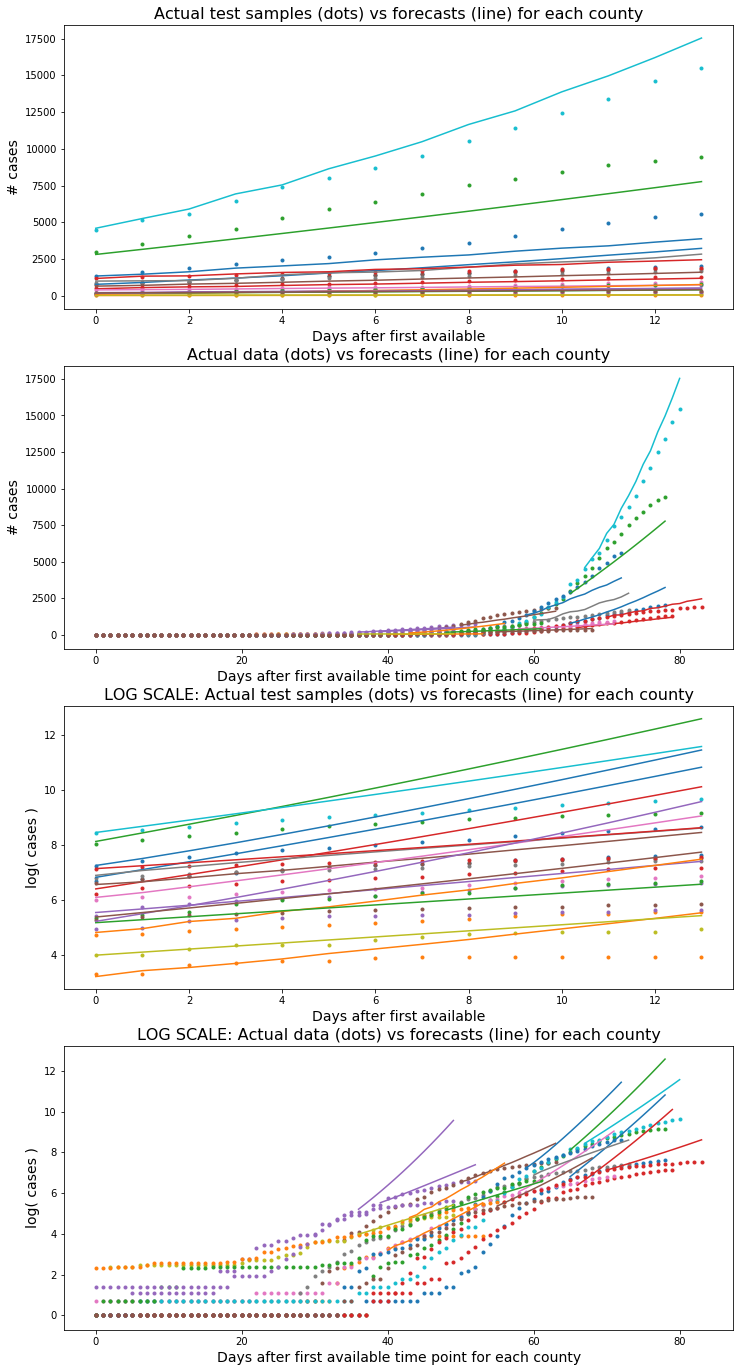

In [101]:
# ARIMA for each county, treating counties as independent 
# note: autoarima has a lot of output, scroll to plot at bottom of cell output

# use counties with at least this many days (keep in mind last 7+ for testing)
min_days = 50
test_size=14 # predicting last two weeks

counts_mask = [str(c)[:5] == '2020-' for c in cases_df.columns]

# put log on same subplots
fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(12,24))
axs[0].set_title('Actual test samples (dots) vs forecasts (line) for each county', size=16)
axs[0].set_xlabel('Days after first available', size=14)
axs[0].set_ylabel('# %s' % cases_or_deaths, size=14)

axs[1].set_title('Actual data (dots) vs forecasts (line) for each county', size=16)
axs[1].set_xlabel('Days after first available time point for each county', size=14)
axs[1].set_ylabel('# %s' % cases_or_deaths, size=14)


axs[2].set_title('LOG SCALE: Actual test samples (dots) vs forecasts (line) for each county', size=16)
axs[2].set_xlabel('Days after first available', size=14)
axs[2].set_ylabel('log( %s )' % cases_or_deaths, size=14)

axs[3].set_title('LOG SCALE: Actual data (dots) vs forecasts (line) for each county', size=16)
axs[3].set_xlabel('Days after first available time point for each county',size=14)
axs[3].set_ylabel('log( %s )' % cases_or_deaths, size=14)


for i in range(len(cases_df)):
    if cases_or_deaths == 'cases':
        data = np.array(cases_df.iloc[i,counts_mask].values, dtype='float')
    else:
        data = np.array(deaths_df.iloc[i,counts_mask].values, dtype='float')

 
    # data should be a 1d array of counts over time
    # currently start from first date with no missing values (different for each county)
    first_nonmiss = np.where(~np.isnan(data))[0][0]
    data = data[first_nonmiss:] 
    if len(data) < min_days:
        continue
        
    for use_log_counts in (False, True): # repeat fit without and with taking log
        if use_log_counts:
            data = np.log(data)
        j = 2*int(use_log_counts)
        
        # split data
        train, test = model_selection.train_test_split(data, test_size=test_size)

        # fit model
        # auto_arima automatically chooses parameters if not specified. can slow if d not set
        # m = 1, means non-seasonal
        arima_fitted = pm.auto_arima(train, error_action='ignore', trace=True,
                              suppress_warnings=True, maxiter=50, m=1)
        print('Selected ARIMA order', arima_fitted.get_params()['order'])

        # forecast
        forecasts = arima_fitted.predict(n_periods=test.shape[0])  # predict N steps into the future

        # Plot actual test vs. forecasts
        x = np.arange(test.shape[0])  # here, x is date
        forecast_line = axs[0 + j].plot(x, forecasts)
        if not use_log_counts: # want same color for log plots as well
            color = forecast_line[0].get_color()
        axs[0+j].scatter(x, test, marker='.', c=color)


        # same, but showing training data too
        x = np.arange(data.shape[0])
        axs[1 + j].scatter(x, data, c=color, marker='.')
        #axs[1].plot(x[:-test_size], train, c=color, marker='.') # train line
        axs[1 + j].plot(x[-test_size:], forecasts, c=color) # forecast line




/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=601.701, BIC=615.361, Time=0.042 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=609.344, BIC=613.897, Time=0.004 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=610.690, BIC=617.520, Time=0.095 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=609.213, BIC=616.043, Time=0.016 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=607.560, BIC=609.837, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=600.438, BIC=611.822, Time=0.035 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=599.231, BIC=608.337, Time=0.029 seconds
Fit ARIMA: (0, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=599.969, BIC=611.352, Time=0.035 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=607.409, BIC=616.516, Time=0.025 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=588.146, BIC=601.806, Time=0.066 seco

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=331.176, BIC=340.842, Time=0.137 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=360.575, BIC=363.797, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=341.073, BIC=345.905, Time=0.011 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=329.463, BIC=334.296, Time=0.030 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=358.623, BIC=360.234, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=329.173, BIC=337.227, Time=0.086 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=329.176, BIC=337.231, Time=0.075 seconds
Near non-in

Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=781.969, BIC=797.906, Time=0.150 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=793.811, BIC=802.917, Time=0.035 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=787.975, BIC=801.635, Time=0.075 seconds
Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=791.515, BIC=805.175, Time=0.102 seconds
Fit ARIMA: (3, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=786.039, BIC=804.252, Time=0.158 seconds
Total fit time: 0.970 seconds
i 183 Selected ARIMA order (2, 2, 3)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=9.503, BIC=23.163, Time=0.130 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=36.048, BIC=40.601, Time=0.009 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=24.225, BI

Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=566.563, BIC=582.596, Time=0.139 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=566.025, BIC=582.058, Time=0.140 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=601.769, BIC=610.931, Time=0.028 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=586.283, BIC=600.025, Time=0.063 seconds
Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=576.627, BIC=590.370, Time=0.057 seconds
Fit ARIMA: (3, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=567.256, BIC=585.579, Time=0.164 seconds
Near non-invertible roots for order (3, 2, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root t

Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=489.616, BIC=501.875, Time=0.068 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=488.936, BIC=499.151, Time=0.031 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=489.277, BIC=503.578, Time=0.113 seconds
Total fit time: 0.473 seconds
i 199 Selected ARIMA order (2, 2, 1)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-6.160, BIC=6.202, Time=0.093 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3.692, BIC=7.813, Time=0.008 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2.133, BIC=8.315, Time=0.111 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2.394, BIC=8.575, Time=0.015 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=15.759, BIC=17.819, Time=0.004 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-6.794, BIC=3.509, Time=0.053 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=T

Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=627.685, BIC=638.709, Time=0.078 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=623.622, BIC=634.646, Time=0.047 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=621.355, BIC=636.788, Time=0.073 seconds
Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=619.852, BIC=633.080, Time=0.067 seconds
Fit ARIMA: (3, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=622.866, BIC=633.890, Time=0.050 seconds
Fit ARIMA: (4, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=621.449, BIC=636.881, Time=0.092 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=639.039, BIC=647.857, Time=0.022 seconds
Fit ARIMA: (4, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=620.142, BIC=633.370, Time=0.060 seconds
Fit ARIMA: (4, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=622.241, BIC=639.878, Time=0.123 seconds
Total fit time: 0.716 seconds
i 205 Selected ARIMA order (3, 2, 1)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0

Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-19.769, BIC=-9.943, Time=0.067 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-15.055, BIC=-11.780, Time=0.013 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-13.143, BIC=-8.230, Time=0.012 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-13.114, BIC=-8.202, Time=0.016 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=5.529, BIC=7.166, Time=0.006 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-21.278, BIC=-13.090, Time=0.069 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-16.043, BIC=-9.493, Time=0.022 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-13.379, BIC=-6.829, Time=0.058 seconds
Fit ARIMA: (1, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=-20.160, BIC=-10.334, Time=0.082 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=-21.362, BIC=-13.174, Time=0.042 seconds
Fit ARIMA: (0, 1, 4)x(0, 0, 0, 0) (constant=True

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=918.579, BIC=925.491, Time=0.019 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=909.242, BIC=916.155, Time=0.031 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=941.035, BIC=943.340, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=880.129, BIC=891.649, Time=0.102 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=896.520, BIC=908.040, Time=0.062 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=873.348, BIC=889.477, Time=0.143 seconds
Fit ARIMA: (3, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=898.500, BIC=912.324, Time=0.086 seconds
Fit ARIMA: (4, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=875.080, BIC=893.512, Time=0.157 seconds
Fit ARIMA: (3, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=874.607, BIC=893.0

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=343.139, BIC=352.640, Time=0.084 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=347.176, BIC=350.344, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=346.333, BIC=351.083, Time=0.018 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=343.136, BIC=347.886, Time=0.015 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=346.346, BIC=347.930, Time=0.082 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=344.482, BIC=350.816, Time=0.031 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=343.286, BIC=349.620, Time=0.027 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=344.154, BIC=352.071, Time=0.053 seconds
Total fit time: 0.315 seconds
i 1115 Selected ARIMA order (0, 2, 1)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2.844, BIC=12.510, Tim

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater



Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=282.171, BIC=293.643, Time=0.053 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=310.015, BIC=313.839, Time=0.004 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=288.347, BIC=294.083, Time=0.009 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=280.554, BIC=286.290, Time=0.015 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=308.090, BIC=310.002, Time=0.004 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=280.505, BIC=288.153, Time=0.017 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=282.454, BIC=292.014, Time=0.040 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=283.820, BIC=293.380, Time=0.067 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=280.920, BIC=288.

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-23.800, BIC=-14.135, Time=0.092 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-24.774, BIC=-21.552, Time=0.005 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-22.910, BIC=-18.078, Time=0.018 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-23.009, BIC=-18.176, Time=0.020 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-14.746, BIC=-13.135, Time=0.006 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-21.263, BIC=-14.820, Time=0.033 seconds
Total fit time: 0.176 seconds
i 1558 Selected ARIMA order (0, 1, 0)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=423.277, BIC=432.435, Time=0.074 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=432.401, BIC=435.454, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=430.825, BIC=435.404, Time=0.014 seconds
Fit ARIMA: (0, 2, 1)x(0,

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=453.417, BIC=462.575, Time=0.087 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=459.726, BIC=462.779, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=461.670, BIC=466.250, Time=0.014 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=461.441, BIC=466.020, Time=0.018 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=458.591, BIC=460.118, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=457.530, BIC=465.162, Time=0.058 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=454.300, BIC=461.932, Time=0.073 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=455.571, BIC=466.256, Time=0.103 seconds
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=455.394, BIC=466.078, Time=0.100 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=459.553, BIC=465.658, Time=0.047 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (cons

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=256.389, BIC=265.721, Time=0.092 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=286.001, BIC=289.112, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=263.208, BIC=267.874, Time=0.010 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=257.291, BIC=261.957, Time=0.037 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=284.114, BIC=285.669, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=254.395, BIC=262.172, Time=0.063 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=256.626, 

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=234.060, BIC=244.041, Time=0.082 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=252.518, BIC=255.845, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=233.204, BIC=238.194, Time=0.009 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=231.926, BIC=236.916, Time=0.014 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=250.644, BIC=252.308, Time=0.003 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=230.968, BIC=237.623, Time=0.015 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=232.925, BIC=241.243, Time=0.022 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=232.918, BIC=241.236, Time=0.026 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=231.407, BIC=238.062, Time=0.015 seconds
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=232.346, BIC=239.000, Time=0.017 seco

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=419.628, BIC=431.672, Time=0.102 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=458.323, BIC=462.338, Time=0.004 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=455.519, BIC=461.541, Time=0.016 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=442.358, BIC=448.380, Time=0.013 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=456.323, BIC=458.331, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=439.305, BIC=449.342, Time=0.028 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=428.603, BIC=438.640, Time=0.032 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=421.585, BIC=435.636, Time=0.113 seconds
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=421.520, BIC=435.571, Time=0.122 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=444.314, BIC=452.344, Time=0.025 seconds
Fit ARIMA: (1, 2, 3)x(0, 0, 0, 0) (cons

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=282.984, BIC=290.616, Time=0.036 seconds
Total fit time: 0.186 seconds
i 2302 Selected ARIMA order (1, 2, 0)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-0.344, BIC=8.988, Time=0.076 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=0.689, BIC=3.799, Time=0.005 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=0.353, BIC=5.019, Time=0.012 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=1.056, BIC=5.722, Time=0.015 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=14.204, BIC=15.759, Time=0.005 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-1.555, BIC=6.222, Time=0.050 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-3.238, BIC=2.984, Time=0.022 seconds
Fit ARIMA: (0, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=-1.733, BIC=6.044, Time=0.076 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True);

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=359.989, BIC=370.415, Time=0.118 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=379.221, BIC=382.696, Time=0.003 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=377.412, BIC=382.625, Time=0.012 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=365.175, BIC=370.388, Time=0.016 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=377.420, BIC=379.158, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=367.328, BIC=376.016, Time=0.047 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=365.503, BIC=374.191, Time=0.034 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=367.220, BIC=379.383, Time=0.159 seconds
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=365.595, BIC=377.758, Time=0.123 seconds
Near non-invertible roots for order (2, 2, 3)(0, 0, 0, 0); setting score to inf (at least on

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=134.097, BIC=138.676, Time=0.040 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=151.359, BIC=152.886, Time=0.004 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=135.626, BIC=143.258, Time=0.036 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=137.325, BIC=144.956, Time=0.058 seconds
Near non-invertible roots for order (2, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=141.325, BIC=152.010, Time=0.144 seconds
Near non-invertible roots for order (3, 2, 2)

Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=310.042, BIC=320.609, Time=0.079 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=323.141, BIC=326.664, Time=0.004 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=315.574, BIC=320.858, Time=0.011 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=308.266, BIC=313.550, Time=0.015 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=321.141, BIC=322.903, Time=0.003 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=309.129, BIC=316.174, Time=0.047 seconds
Near non-invertible roots for order (1, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=309.478, BIC=316.523, Time=0.051 seconds
Near non-invertible roots for order (0, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: 

/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


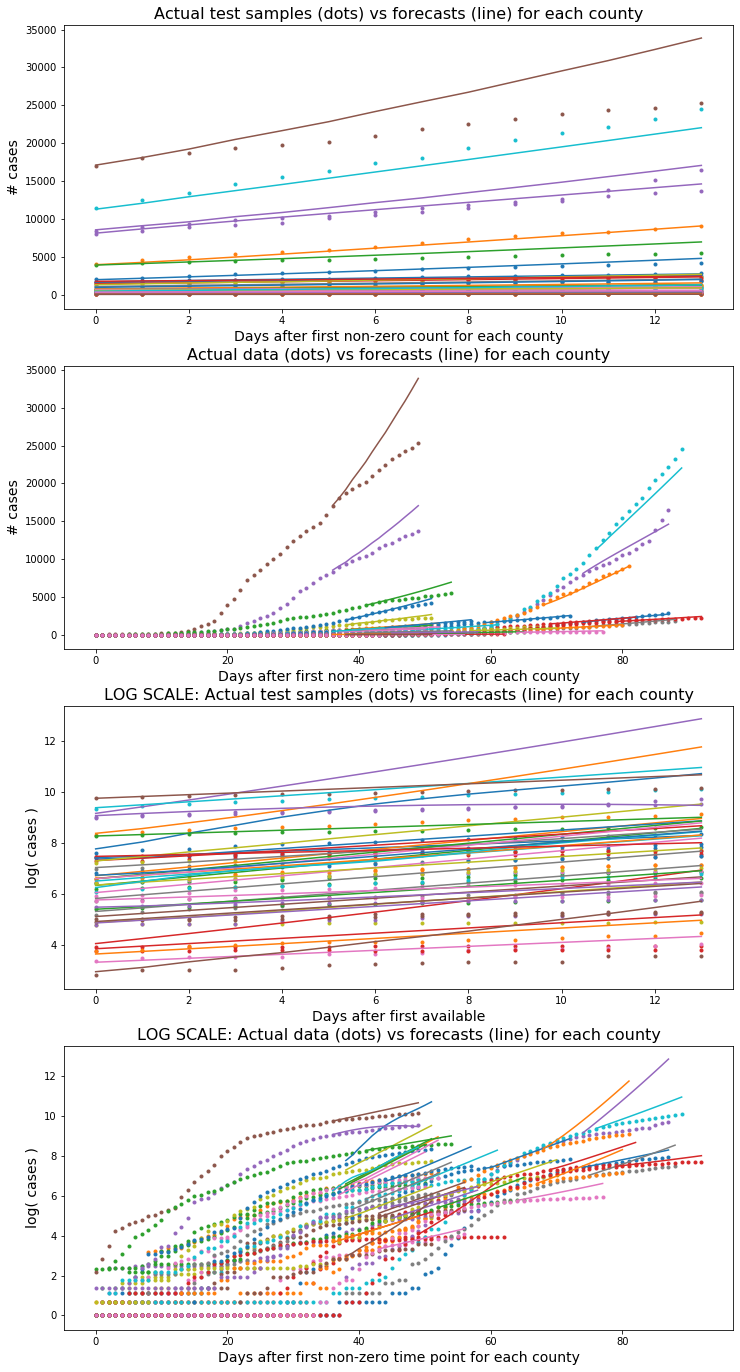

In [18]:
# ARIMA for each county, treating counties as independent, only using non-zero counts for cases
# note: autoarima has a lot of output, scroll to plot at bottom of cell output

# Note: not many counties with lot of non-zero death days. Also, ARIMA model not constrained to be non-decreasing
# did poorly on predicting deaths

# use counties with at least this many days (keep in mind last 7+ for testing)
min_days = 50
test_size=14 # predicting last two weeks

counts_mask = [str(c)[:5] == '2020-' for c in cases_df.columns]
cases_or_deaths = 'cases'

# put log on same subplots
fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(12,24))
axs[0].set_title('Actual test samples (dots) vs forecasts (line) for each county', size=16)
axs[0].set_xlabel('Days after first non-zero count for each county', size=14)
axs[0].set_ylabel('# %s' % cases_or_deaths, size=14)

axs[1].set_title('Actual data (dots) vs forecasts (line) for each county', size=16)
axs[1].set_xlabel('Days after first non-zero time point for each county', size=14)
axs[1].set_ylabel('# %s' % cases_or_deaths, size=14)


axs[2].set_title('LOG SCALE: Actual test samples (dots) vs forecasts (line) for each county', size=16)
axs[2].set_xlabel('Days after first available', size=14)
axs[2].set_ylabel('log( %s )' % cases_or_deaths, size=14)

axs[3].set_title('LOG SCALE: Actual data (dots) vs forecasts (line) for each county', size=16)
axs[3].set_xlabel('Days after first non-zero time point for each county',size=14)
axs[3].set_ylabel('log( %s )' % cases_or_deaths, size=14)


for i in range(len(cases_df)):
    if cases_or_deaths == 'cases':
        data = np.array(cases_df.iloc[i,counts_mask].values, dtype='float')
    else:
        data = np.array(deaths_df.iloc[i,counts_mask].values, dtype='float')

 
    # data should be a 1d array of counts over time
    # currently start from first date with no missing values (different for each county)
    first_nonmiss = np.where(~np.isnan(data))[0][0]
    data = data[first_nonmiss:]
    first_nonzero = np.where(data > 0.0)[0][0]
    data = data[first_nonzero:]
    if len(data) < min_days:
        continue
        
    for use_log_counts in (False, True): # repeat fit without and with taking log
        if use_log_counts:
            data = np.log(data)
        j = 2*int(use_log_counts)
        
        # split data
        train, test = model_selection.train_test_split(data, test_size=test_size)

        # fit model
        # auto_arima automatically chooses parameters if not specified. can slow if d not set
        # m = 1, means non-seasonal
        arima_fitted = pm.auto_arima(train, error_action='ignore', trace=True,
                              suppress_warnings=True, maxiter=50, m=1)
        print('i', i, 'Selected ARIMA order', arima_fitted.get_params()['order'])

        # forecast
        forecasts = arima_fitted.predict(n_periods=test.shape[0])  # predict N steps into the future

        # Plot actual test vs. forecasts
        x = np.arange(test.shape[0])  # here, x is date
        forecast_line = axs[0 + j].plot(x, forecasts)
        if not use_log_counts: # want same color for log plots as well
            color = forecast_line[0].get_color()
        axs[0+j].scatter(x, test, marker='.', c=color)


        # same, but showing training data too
        x = np.arange(data.shape[0])
        axs[1 + j].scatter(x, data, c=color, marker='.')
        #axs[1].plot(x[:-test_size], train, c=color, marker='.') # train line
        axs[1 + j].plot(x[-test_size:], forecasts, c=color) # forecast line




In [ ]:
## prophet: bayesian curve fitting 
# this cell wip
# need to check if intended primarily for seasonal data
## has linear and logistic growth models



from fbprophet import Prophet
# https://facebook.github.io/prophet/docs/

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=??)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()




#endogenous: response, dependent
#exogenous: predictor, independent



In [ ]:
# convert dates to numbers for plt
#x = matplotlib.dates.date2num(train_cases_df.columns[3:])

## linear model: regress log(deaths or cases) against demographics + interventions + counts
## linear model: regress log(deaths) against deaths in all counties on previous days
#            maybe too few sample - coeffs would be different for pred LA vs other county
# also try predicting raw deaths, increase in deaths, deaths per pop size
## rf, arima, curve fitting

## regression, arimax model. 
# delta log(cases_county_x) = beta * X_demographic + phi_(t-1) * cases_(all counties, t-1) + ....

In [ ]:
# TODO arima using other counties, deaths, state-level testing as exogenous 

# TODO add proportion or number tested as feature
# state-level data available here, including time series starting from feb 28:
# https://covidtracking.com/data

# TODO will output predictions from ARIMA and LSTM models in the prediction_csv/ directory

# TODO add seasonality by week - typically backlog of cases over weekend. 
# (maybe difficult if training on only a couple weeks)
